In [1]:
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

from dataloader import PieceDetectorDataset, PieceDetectorCOGDataset
from models import PieceDetector
from torchvision.datasets import CocoDetection
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert

import glob
import os
from PIL import Image
import json
import sqlite3

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
root_folder = "d:/Projects/Chess Detection Data/data_generation/backups/old_data/images_old"
json_file = "d:/Projects/Chess Detection Data/data_generation/backups/old_data/images_old/piece_coco.json"
dataset = PieceDetectorDataset(root=root_folder, json_file=json_file, size=(1000, 1000))

loading annotations into memory...
Done (t=1.07s)
creating index...
index created!
Piece Detector Dataset initialized!


In [3]:
tranform_320 = transforms.Compose([transforms.Resize(320), transforms.ToTensor()])
tranform_1000 = transforms.Compose([transforms.Resize(1000), transforms.ToTensor()])

In [4]:
load = "models/checkpoints/piece_detector/320_faster_rcnn/synthetic_weight01"
detector = PieceDetector(pretrained=True).to(device)
detector.load_state_dict(torch.load(load, map_location=device))
detector.eval()

PieceDetector(
  (detector): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         

In [26]:
imgs = os.listdir('d:/Projects/Chess Detection Data/chessred/chessred/images/0/')
img = Image.open(f'd:/Projects/Chess Detection Data/chessred/chessred/images/0/{imgs[-12]}')
img_320 = tranform_320(img)
img_1000 = tranform_1000(img)

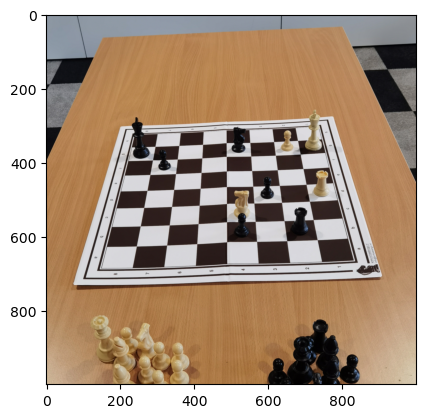

In [27]:
og_img = (img_1000 * 255).to(torch.uint8).detach()
plt.imshow(og_img.permute(1, 2, 0))
plt.show()

In [28]:
# img, _ = dataset[0]
CONFIDENCE_THRESHOLD = 0.5
out = detector(img_320.unsqueeze(0).to(device))
boxes_320 = out[0]['boxes']
boxes_320 = boxes_320[out[0]['scores'] > CONFIDENCE_THRESHOLD]
labels = out[0]['labels']
labels = labels[out[0]['scores'] > CONFIDENCE_THRESHOLD]
labels = [dataset.classes[l]["name"] for l in labels]

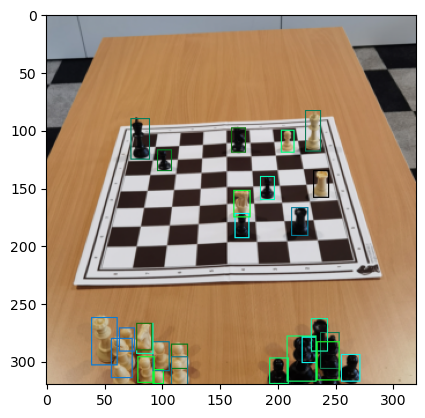

In [29]:
# box_int = 16
# out_img = draw_bounding_boxes((img_320 * 255).to(torch.uint8).detach(), boxes_320[box_int:box_int+1], labels[box_int:box_int+1])
out_img = draw_bounding_boxes((img_320 * 255).to(torch.uint8).detach(), boxes_320)
plt.imshow(out_img.detach().permute(1, 2, 0))
plt.show()

In [30]:
# converts the boxes from 320 to 1000 scale
boxes_1000 = boxes_320.clone()
boxes_1000[:,:1] = (boxes_320[:, :1] / img_320.shape[1]) * img_1000.shape[1] #x1
boxes_1000[:,2:3] = (boxes_320[:, 2:3] / img_320.shape[1]) * img_1000.shape[1] #x2

boxes_1000[:,1:2] = (boxes_320[:, 1:2] / img_320.shape[2]) * img_1000.shape[2] #y1
boxes_1000[:,3:] = (boxes_320[:, 3:] / img_320.shape[2]) * img_1000.shape[2] #y2

In [31]:
def generate_unique_piece_colors(labels):
    """ takes input a list of piece names (obtains from the labels from model ouput) and 
    returns a list of unqiue colors for bbox representation
    """
    # order: PNBRQK pnbrqk
    unique_colors = ["red", "silver", "mediumpurple", "green", "pink", "white",
                     "darkred", "dimgray", "purple", "darkgreen", "palevioletred", "black"]
    piece_order = ["white pawn", "white knight", "white bishop", "white rook", "white queen", "white king",
                   "black pawn", "black knight", "black bishop", "black rook", "black queen", "black king"]

    colors = [unique_colors[piece_order.index(x)] for x in labels]

    return colors

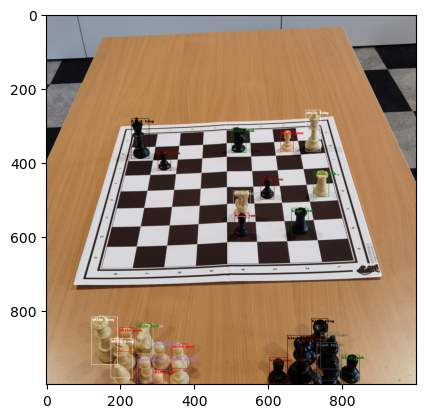

In [32]:
# box_int = 1
# out_img = draw_bounding_boxes(og_img, boxes[box_int:box_int+1], labels[box_int:box_int+1])
out_img = draw_bounding_boxes(og_img, boxes_1000, labels, generate_unique_piece_colors(labels))
plt.imshow(out_img.detach().permute(1, 2, 0))
plt.show()
plt.imsave('./out.png', out_img.detach().permute(1, 2, 0).numpy())